# Ainda em desenvolvimento/teste

In [6]:
#https://www.quantstart.com/articles/Backtesting-An-Intraday-Mean-Reversion-Pairs-Strategy-Between-SPY-And-IWM/
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from enum import Enum
import cointegration_mult as mult
import Cointegration as coint
import datetime

importlib.reload(coint)
importlib.reload(mult)

<module 'cointegration_mult' from 'D:\\trades\\pairs_trading_b3\\cointegration_mult.py'>

In [74]:
class Historic(object):
    def __init__(self):
        self.type_input=TypeInput.Nada
        self.day_input=None
        self.price_y_input=None
        self.price_x_input=None
        self.day_output=None
        self.price_y_output=None
        self.price_x_output=None
        self.type_output=TypeOutput.Nada
        self.lot_y=100
        self.lot_x=100
        
    def get(self):
        return [self.type_input.name, self.day_input, self.price_y_input, self.price_x_input,
                self.day_output, self.price_y_output, self.price_x_output, self.type_output.name,
                 self.calculate(), diff_dates(self.day_input, self.day_output)]

    def calculate(self):
        lot = 100
        if (self.type_input == TypeInput.LongShort):
            long_tot = (self.price_y_output*self.lot_y)-(self.price_y_input*self.lot_y)
            short_tot = (self.price_x_input*self.lot_x)-(self.price_x_output*self.lot_x)
            return (long_tot+short_tot)
            
        if (self.type_input == TypeInput.ShortLong):
            short_tot = (self.price_y_input*self.lot_y)-(self.price_y_output*self.lot_y)
            long_tot = (self.price_x_output*self.lot_x)-(self.price_x_input*self.lot_x)
            return (long_tot+short_tot)
        return 0
    
def diff_dates(date1, date2):
    date_one = datetime.datetime.strptime(date1, '%Y-%m-%d')
    date_two = datetime.datetime.strptime(date2, '%Y-%m-%d')
    return abs((date_one-date_two).days)

class TypeOutput(Enum):
    Nada = 0
    Zerado = 1
    Disintegrated = 2
    TakeProfit = 3
    StopLoss = 4
    
class TypeInput(Enum):
    Nada=0
    LongShort=1
    ShortLong=2

In [14]:
path_data_cart = 'datasets/data_cart.csv'
path_data_yahoo = 'datasets/data_yahoo_adj.csv'
path_data = 'datasets/data.csv'

In [15]:
data = pd.read_csv(path_data_yahoo, index_col=0)
data = data[::-1]
pairs = pd.read_csv('datasets/cointegrated_pairs_mult.csv')

print('{} to {}'.format(data.index[-1], data.index[0]))
print('data: {}'.format(data.shape))
print('pairs: {}'.format(pairs.shape))

2019-05-02 to 2020-07-30
data: (311, 72)
pairs: (2027, 13)


BBSE3: 28.06999969482422 / ITSA4: 10.90999984741211


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


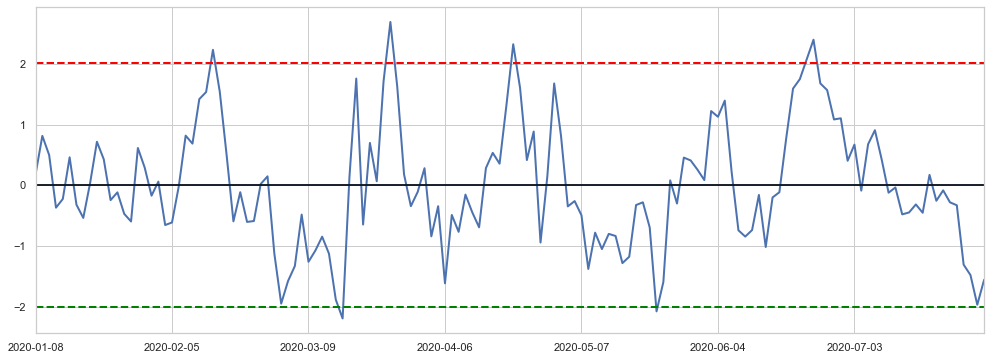

In [16]:
y_symbol = 'BBSE3'
x_symbol = 'ITSA4'
period = 140
print('{}: {} / {}: {}'.format(y_symbol, data[y_symbol][0], x_symbol, data[x_symbol][0]))
mult.plot_residue(mult.residue(data[y_symbol], data[x_symbol], period))

In [86]:
class BackTest(object):
    def __init__(self):
        self.counter_stoploss=0
        self.counter_takeprofit=0
        self.counter_takeprofit=0
        self.counter_oper=0
        self.counter_zerado=0
        self.day_start=None
        
        self.finance_gain=0
        self.finance_loss=0
        self.finance_zerar_loss=0
        self.finance_zerar_gain=0
        self.historic = Historic()
        self.list_historic=[]
        
    def list_historic(self):
        return self.list_historic;
    
    def execute(self, desv_input=2, desv_stop=3, period=100):
        days = data.index[::-1].tolist()
        for day in days:
            test = data[data.index <= day]
            if (len(test) < period):
                continue

            if (self.day_start == None):
                self.day_start = day

            self.y_values, self.x_values = mult.get_values(test[y_symbol], test[x_symbol], period)
            resid = mult.residue(self.y_values, self.x_values, period)
            z_resid = mult.zscore(resid)
            
            check = mult.check_cointegration(self.y_values, self.x_values, period)
            if(check['is_stationary']==False):
                self.zerar(day)
                continue
            
            # procura por operações
            if (self.check_trade() == False):
                # oper short/long
                if (z_resid[0] >= desv_input):
                    self.short(day)
                    
                # oper long/short
                if (z_resid[0] <= -desv_input):
                    self.long(day)

            # gerencia operação aberta
            if (self.check_trade()):
                if (self.isShort()):
                    if (z_resid[0] >= desv_stop):# check stop loss
                        self.stop(day)
                    if (z_resid[0] <= 0):# check take profit
                        self.take(day)

                if (self.isLong()):                    
                    if (z_resid[0] <= -desv_stop):#  check stop loss
                        self.stop(day)
                    if (z_resid[0] >= 0):# check take profit
                        self.take(day)
        
        self.zerar(day)
                    
    def check_trade(self):
        return self.isShort() or self.isLong()
    
    def take(self, day):
        self.finance_gain += self.calculate()        
        self.counter_takeprofit+=1
        self.define_historic_output(day, TypeOutput.TakeProfit)
        self.startNew()
        
    def stop(self, day):
        self.finance_loss += self.calculate()        
        self.counter_stoploss+=1
        self.define_historic_output(day, TypeOutput.StopLoss)
        self.startNew()
        
    def long(self, day):
        self.counter_oper+=1
        self.define_historic_input(day, TypeInput.LongShort)
    
    def short(self, day):
        self.counter_oper+=1
        self.define_historic_input(day, TypeInput.ShortLong)
    
    def zerar(self, day):
        if (self.check_trade()):
            self.define_historic_output(day, TypeOutput.Disintegrated)
            self.counter_zerado+=1
            value = self.calculate()
            if(value > 0):
                self.finance_zerar_gain += value
                self.finance_gain += value
            else:
                self.finance_zerar_loss += value
                self.finance_loss += value
                
            self.startNew()
            return True
        return False
    
    def define_historic_input(self, day, typeInput):
        self.historic.day_input=day
        self.historic.price_y_input=self.y_values[0]
        self.historic.price_x_input=self.x_values[0]
        self.historic.type_input=typeInput
    
    def define_historic_output(self, day, type_outPut):
        self.historic.day_output=day
        self.historic.price_y_output=self.y_values[0]
        self.historic.price_x_output=self.x_values[0]
        self.historic.type_output=type_outPut
        
    def startNew(self):
        self.list_historic.append(self.historic)
        self.historic = Historic()
    
    def isShort(self):
        return self.historic.type_input == TypeInput.ShortLong
    
    def isLong(self):
        return self.historic.type_input == TypeInput.LongShort

    def calculate(self):
        lot = 100
        if (self.isLong()):
            long_tot = (self.y_values[0]*lot)-(self.historic.price_y_input*lot)
            short_tot = (self.historic.price_x_input*lot)-(self.x_values[0]*lot)
            return (long_tot+short_tot)
            
        if (self.isShort()):
            short_tot = (self.historic.price_y_input*lot)-(self.y_values[0]*lot)
            long_tot = (self.x_values[0]*lot)-(self.historic.price_x_input*lot)
            return (long_tot+short_tot)
        return 0

In [87]:
back = BackTest()
back.execute(period=period)

rows = []
for his in back.list_historic:
    rows.append(his.get())
    
hist = pd.DataFrame(rows, columns=['Oper', 'Ent. Data', 'Ent. Pç Dep', 'Ent. Pç Ind', 'Sai. Data', 'Sai. Pç Dep', 
                                   'Sai. Pç Ind', 'Sai. tipo', 'Result', 'Dias'])
hist

,Oper,Ent. Data,Ent. Pç Dep,Ent. Pç Ind,Sai. Data,Sai. Pç Dep,Sai. Pç Ind,Sai. tipo,Result,Dias
0,LongShort,2019-11-18,31.021742,13.289758,2019-11-19,31.140705,13.113864,Disintegrated,29.485703,1
1,ShortLong,2019-12-18,34.801086,13.677907,2020-01-27,33.204098,12.786934,TakeProfit,70.601559,40
2,LongShort,2020-02-27,31.469999,11.823483,2020-03-12,25.209999,9.249075,Disintegrated,-368.559170,14
3,LongShort,2020-05-22,23.510000,8.839999,2020-06-19,28.790001,10.410000,TakeProfit,371.000004,28
4,LongShort,2020-07-29,28.240000,11.130000,2020-07-30,28.070000,10.910000,Disintegrated,5.000019,1


In [84]:
print('TakeProfit: {}'.format(hist['Result'][hist['Sai. tipo'] == 'TakeProfit'].sum()))
print('Disintegrated: {}'.format(hist['Result'][hist['Sai. tipo'] == 'Disintegrated'].sum()))
print('StopLoss: {}'.format(hist['Result'][hist['Sai. tipo'] == 'StopLoss'].sum()))

TakeProfit: 441.6015625000002
Disintegrated: -334.07344818115234
StopLoss: 0.0


Days: 1


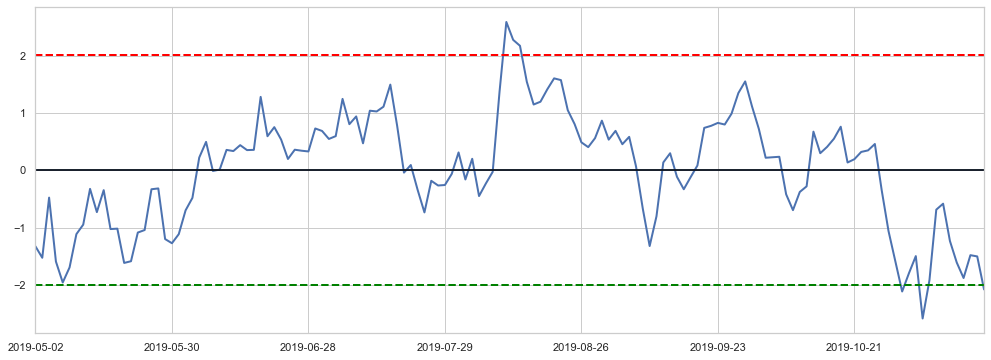

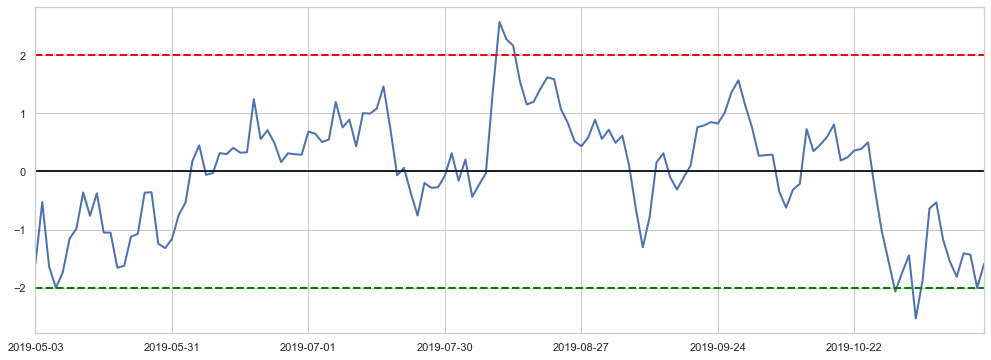

In [94]:
oper = hist.iloc[0]

day_start = oper['Ent. Data']
day_end = oper['Sai. Data']
test = data[data.index <= day_start]
test_stop = data[data.index <= day_end]
test_simu = data[(data.index >= day_start) & (data.index <= day_end)]

print('Days: {}'.format(abs(len(test)-len(test_stop))))

resid = mult.residue(test[y_symbol], test[x_symbol], period)
mult.plot_residue(resid)
mult.plot_residue(mult.residue(test_stop[y_symbol], test_stop[x_symbol], period))

In [36]:
test_simu[::1][[y_symbol, x_symbol]].to_excel('datasets/backtest/backtest.xlsx')